In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt

from rna_folding.evaluate import f1_score
from rna_folding.parsing import gpmap_to_dict

In [2]:
parser = argparse.ArgumentParser()
args = parser.parse_args([])
args.genotypes = "/home/lgold/phd/research/projects/connectivity/rna_folding/data/RNA12/input/RNA12_gt.txt.1"
args.phenotypes = "/home/lgold/phd/research/projects/connectivity/rna_folding/data/RNA12/output/RNA12_ph.txt.1"
args.reference = "/home/lgold/phd/research/projects/connectivity/rna_folding/data/sgreenbury_gp-maps-nav/gp_maps/RNA_12/gp_map.txt"
    

In [61]:
gp_map = gpmap_to_dict(args.phenotypes, args.genotypes)
    
with open(args.reference, "r") as ref:
    ref_dict = dict([line.strip().split() for line in ref])

f1_scores = []
f1_scores_avg = {}
for query_seq in gp_map:
    ref_ss = ref_dict[query_seq]
    # loop over suboptimal strucs and compare to ref
    f1 = [f1_score(ref_ss, query_ss) 
            for query_ss in gp_map[query_seq]]
    f1_scores.append(f1)
    f1_scores_avg[query_seq] = np.mean(f1)

f1_score_avg_no_zero = [i for i in f1_scores_avg.values() if i > 0]

Script code above

In [71]:
unfolded = "............"

both_unfold_count = 0
ref_unfold_count = 0
unfolded_gts = []
for seq, score in f1_scores_avg.items():
    if score == 0:
        if ref_dict[seq] == unfolded:
            ref_unfold_count += 1
        if gp_map[seq][0] == unfolded:
            unfolded_gts.append(seq)
        if ref_dict[seq] == unfolded and gp_map[seq][0] == unfolded:
            both_unfold_count += 1

print(both_unfold_count, ref_unfold_count, len(gp_map), len(gp_map)-ref_unfold_count)

1722 326488 335545 9057


In [5]:
count = 0
for i in gp_map.values():
    if i[0] == unfolded:
        count += 1
print(count)

1722


(array([14325304.,        0.,   174539.,        0.,        0.,   989898.,
               0.,  1062890.,        0.,   224585.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

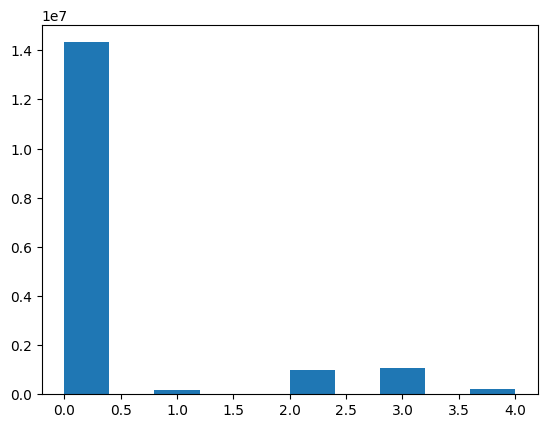

In [6]:
## REF bp histogram

def count_bp(seq):
    bp_count = 0
    for i in seq:
        if i == "(":
            bp_count += 1
    return bp_count

ref_bp_counts = [count_bp(db) for db in ref_dict.values()]
plt.hist(ref_bp_counts)
    

(array([  1722.,      0.,  36289.,      0.,      0., 169045.,      0.,
        116805.,      0.,  11684.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

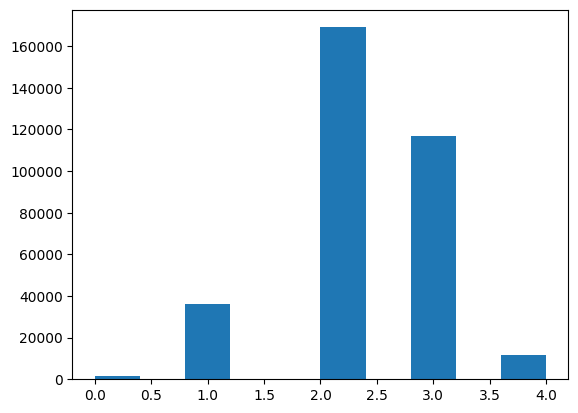

In [7]:
# dont need to take average because suboptimal range is 0 so all have same number of bp
pred_bp_counts = [count_bp(db_list[0]) for db_list in gp_map.values()]
plt.hist(pred_bp_counts)

In [8]:
ref_bp_counts_sorted = []
pred_bp_counts_sorted = []
for seq in gp_map:
    ref_bp_counts_sorted.append(count_bp(ref_dict[seq]))
    pred_bp_counts_sorted.append(count_bp(gp_map[seq][0]))

In [9]:
bp_count_pairs = zip(ref_bp_counts_sorted, pred_bp_counts_sorted)
counts_matrix = np.empty((5,5))
for count_pair in bp_count_pairs:
        counts_matrix[count_pair] += 1
counts_matrix = np.log10(counts_matrix)

/tmp/ipykernel_159326/161440808.py:5: RuntimeWarning: divide by zero encountered in log10
  counts_matrix = np.log10(counts_matrix)


Text(0.5, 1.0, 'log10 counts')

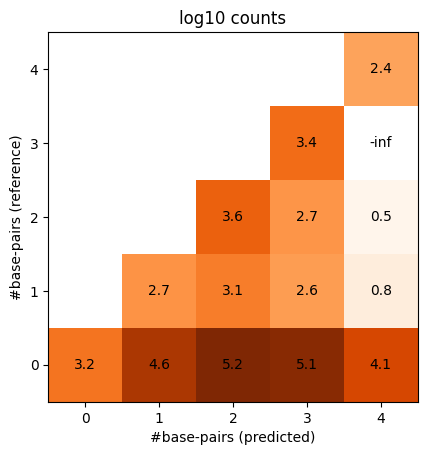

In [10]:
fig, ax = plt.subplots()
ax.imshow(counts_matrix, cmap='Oranges', interpolation='nearest', origin='lower')
for i in range(counts_matrix.shape[0]):
    for j in range(counts_matrix.shape[1]):
        if i <= j:
            if counts_matrix[i, j] == -1:
                ax.text(j, i, "0")
            else:
                ax.text(j, i, "{:.1f}".format(counts_matrix[i, j]), va='center', ha='center')
ax.set_xlabel("#base-pairs (predicted)")
ax.set_ylabel("#base-pairs (reference)")
ax.set_title("log10 counts")

In [33]:
zip(f1_scores, f1_scores_avg)
f1_scores_max = [np.max(scores) for scores in f1_scores]
f1_scores_sorted_on_max = [f1_score_list for _, f1_score_list in sorted(zip(f1_scores_max, f1_scores))]
f1_scores_sorted_on_avg = [f1_score_list for _, f1_score_list in sorted(zip(f1_scores_avg, f1_scores))]

In [64]:
f1_scores_avg_lst = []
f1_scores_max_lst = []
f1_scores_min_lst = []
for scores in f1_scores:
    f1_scores_avg_lst.append(np.mean(scores))
    f1_scores_max_lst.append(np.max(scores))
    f1_scores_min_lst.append(np.min(scores))

f1_scores_sorted_on_avg = [f1_score_list for _, f1_score_list in sorted(zip(f1_scores_avg_lst, f1_scores))]


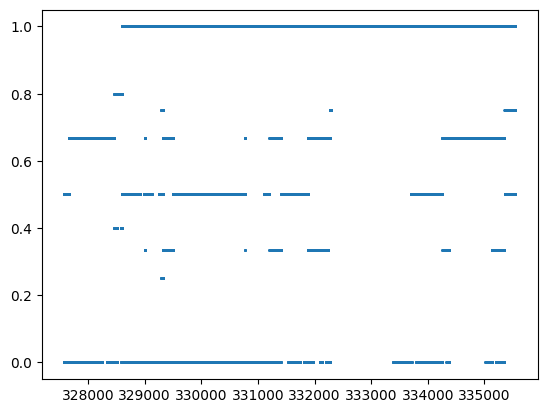

In [65]:
fig, ax = plt.subplots()
x = []
y = []
for i, scores in enumerate(f1_scores_sorted_on_max):
    if np.max(scores) == 0:
        continue
    for score in scores:
        x.append(i)
        y.append(score)

ax.scatter(x, y, s=1)

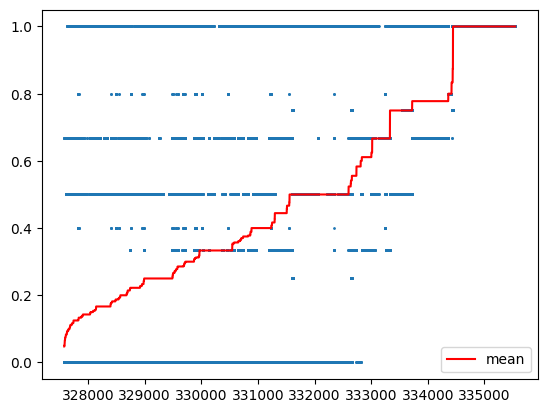

In [67]:
fig, ax = plt.subplots()
x = []
y = []
x_avg = []
avg = []
for i, scores in enumerate(f1_scores_sorted_on_avg):
    if np.max(scores) == 0:
        continue
    x_avg.append(i)
    avg.append(np.mean(scores))
    for score in scores:
        x.append(i)
        y.append(score)

ax.scatter(x, y, s=1)
ax.plot(x_avg, avg, color="red", label="mean")
ax.legend()

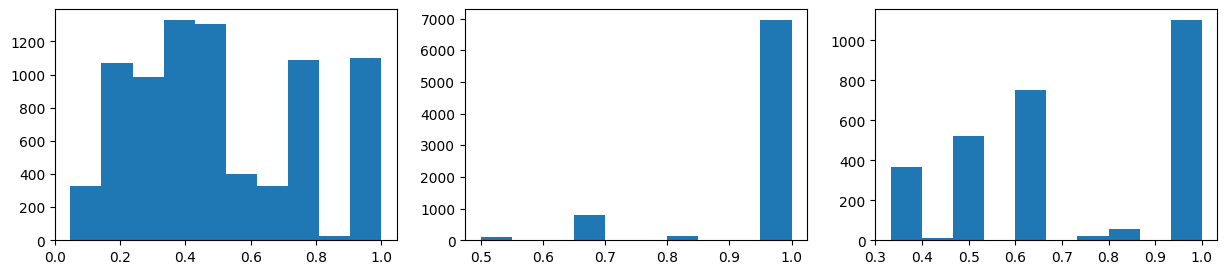

In [69]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 3))
his1 = ax1.hist([i for i in f1_scores_avg_lst if i > 0])
his2 = ax2.hist([i for i in f1_scores_max_lst if i > 0])
his3 = ax3.hist([i for i in f1_scores_min_lst if i > 0])

/tmp/ipykernel_159326/1148465682.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, np.array(f1_bp))[0]


Text(0, 0.5, 'Average F1 score across predictions')

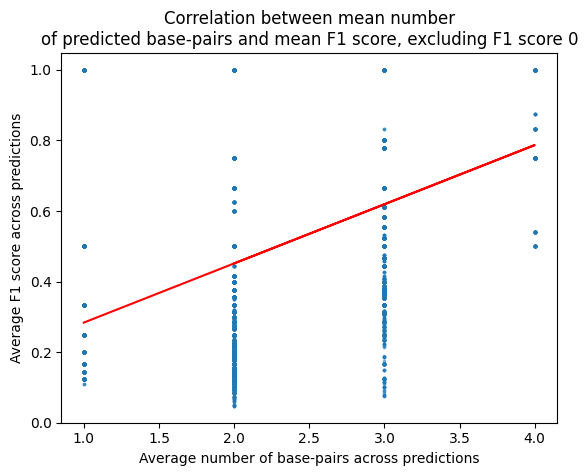

In [93]:
c_bp = []
f1_bp = []
for seq in f1_scores_avg:
    if f1_scores_avg[seq] == 0:
        continue
    f1_bp.append(f1_scores_avg[seq])
    c_bp.append(np.mean([count_bp(db) for db in gp_map[seq]]))
    

c_bp_arr = np.array(c_bp)
A = np.vstack([c_bp_arr, np.ones(len(c_bp))]).T
m, c = np.linalg.lstsq(A, np.array(f1_bp))[0]
plt.plot(c_bp_arr, m*c_bp_arr + c, 'r', label='Fitted line')

plt.scatter(c_bp, f1_bp, alpha=0.5, s=3)
plt.title("Correlation between mean number\nof predicted base-pairs and mean F1 score, excluding F1 score 0")
plt.xlabel("Average number of base-pairs across predictions")
plt.ylabel("Average F1 score across predictions")